# 姿态估计

### 目标
在本章中
- 我们将学习利用calib3d模块在图像中创建一些3D效果。

### 基础
这将是一小部分。在上一次相机校准的会话中，你发现了相机矩阵，失真系数等。给定图案图像，我们可以利用以上信息来计算其姿势或物体在空间中的位置，例如其旋转方式， 对于平面物体，我们可以假设Z = 0，这样，问题就变成了如何将相机放置在空间中以查看图案图像。 因此，如果我们知道对象在空间中的位置，则可以在其中绘制一些2D图以模拟3D效果。 让我们看看如何做。 

我们的问题是，我们想在棋盘的第一个角上绘制3D坐标轴(X,Y,Z)。 X轴为蓝色，Y轴为绿色，Z轴为红色。 因此，实际上Z轴应该感觉像它垂直于我们的棋盘平面。

首先，让我们从先前的校准结果中加载相机矩阵和失真系数。

In [1]:
import numpy as np
import cv2 as cv
import glob

# 加载先前保存的数据
with np.load('output/B.npz') as X:
    mtx, dist, _, _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

现在让我们创建一个函数，绘制，该函数将棋盘上的角（使用cv.findChessboardCorners()获得）和**轴点**绘制为3D轴。

In [2]:
def draw(img, corners, imgpts):
    corner = tuple(np.int32(corners[0].ravel()))   
    img = cv.line(img, corner, tuple(np.int32(imgpts[0].ravel())), (255,0,0), 5)     
    img = cv.line(img, corner, tuple(np.int32(imgpts[1].ravel())), (0,255,0), 5)
    img = cv.line(img, corner, tuple(np.int32(imgpts[2].ravel())), (0,0,255), 5)
    return img

然后，与前面的情况一样，我们创建终止条件，对象点（棋盘上角的3D点）和轴点。 轴点是3D空间中用于绘制轴的点。 我们绘制长度为3的轴（由于我们根据该棋盘尺寸进行了校准，因此单位将以国际象棋正方形的尺寸为单位）。因此我们的X轴从(0,0,0)绘制为(3,0,0)，Y轴也是如此。 对于Z轴，从(0,0,0)绘制为(0,0,-3)。 负号表示它被拉向相机。

In [3]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*7,3), np.float32)

objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

现在，像往常一样，我们加载每个图像。搜索7x6网格。如果找到，我们将使用子角像素对其进行优化。然后使用函数**cv.solvePnPRansac**()计算旋转和平移。一旦有了这些变换矩阵，就可以使用它们将轴点投影到图像平面上。简而言之，我们在图像平面上找到与3D空间中(3,0,0),(0,3,0),(0,0,3)中的每一个相对应的点。一旦获得它们，就可以使用draw()函数从第一个角到这些点中的每个点绘制线条。完毕!!!

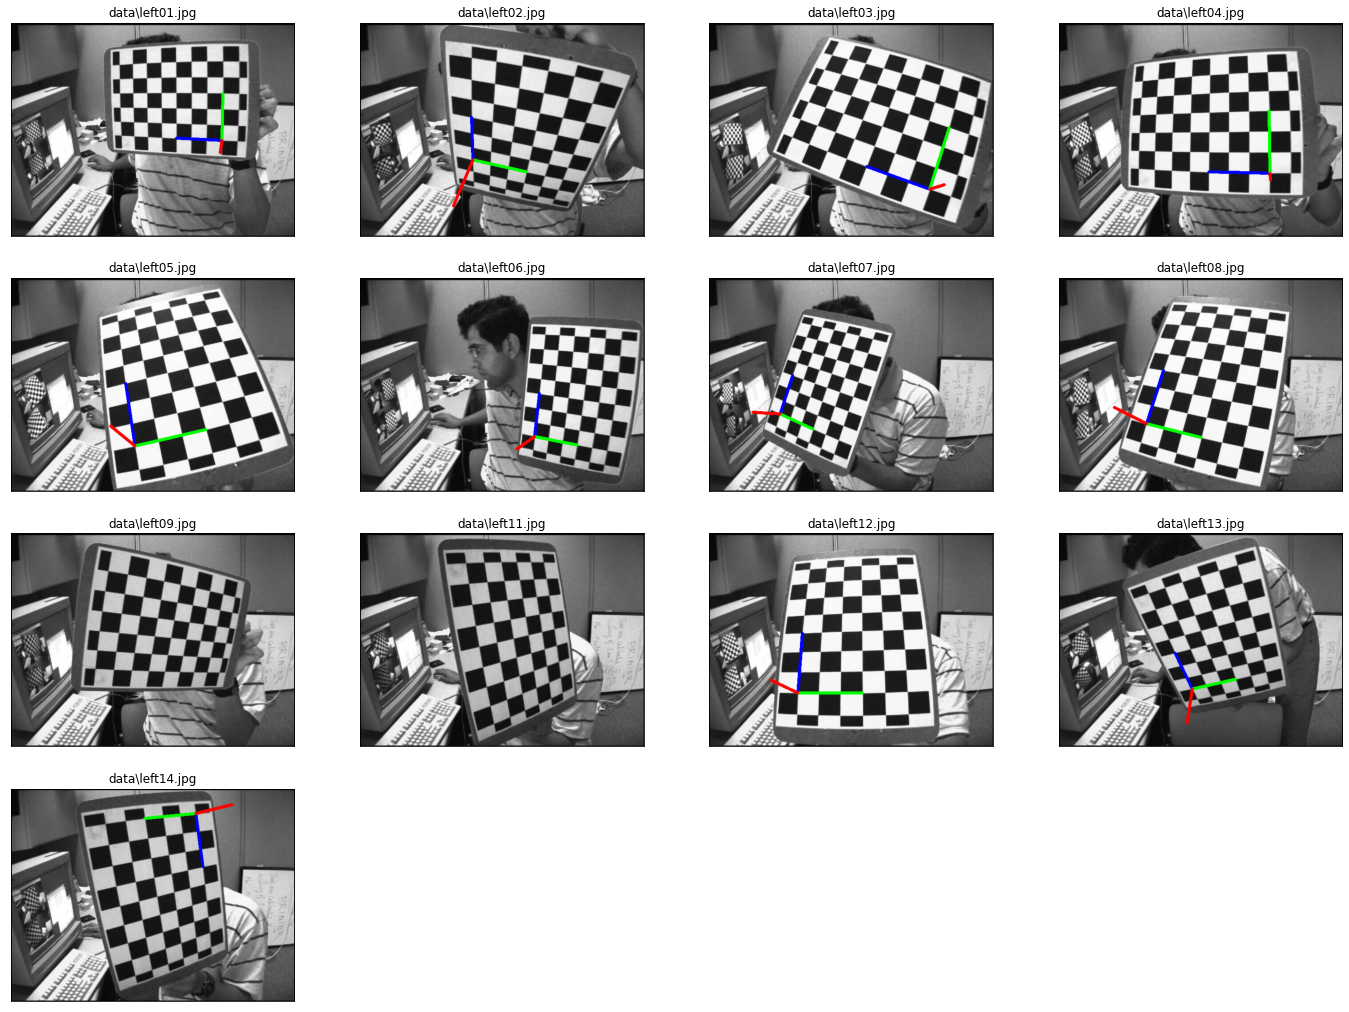

In [4]:
from matplotlib import pyplot as plt

images = glob.glob('data/left*.jpg')

plt.figure(figsize=(24,18))

for i in range(len(images)):
    img = cv.imread(images[i])

    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, (7,6),None)

    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # 找到旋转和平移矢量。
        ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)

        # 将3D点投影到图像平面
        imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)

        img = draw(img,corners2,imgpts)

    plt.subplot(4,4,i+1),plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(images[i])
    plt.xticks([]), plt.yticks([])

plt.show()

#### 绘制立方体
如果要绘制立方体，请如下修改draw()函数和轴点。
修改后的draw()函数:

In [5]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # 用绿色绘制底层
    img = cv.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)

    # 用蓝色绘制高
    for i,j in zip(range(4),range(4,8)):
        img = cv.line(img, tuple(np.int32(imgpts[i])), tuple(np.int32(imgpts[j])),(255),3)

    # 用红色绘制顶层
    img = cv.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    
    return img

修改的轴点。它们是3D空间中多维数据集的8个角：

In [6]:
axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0], [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])

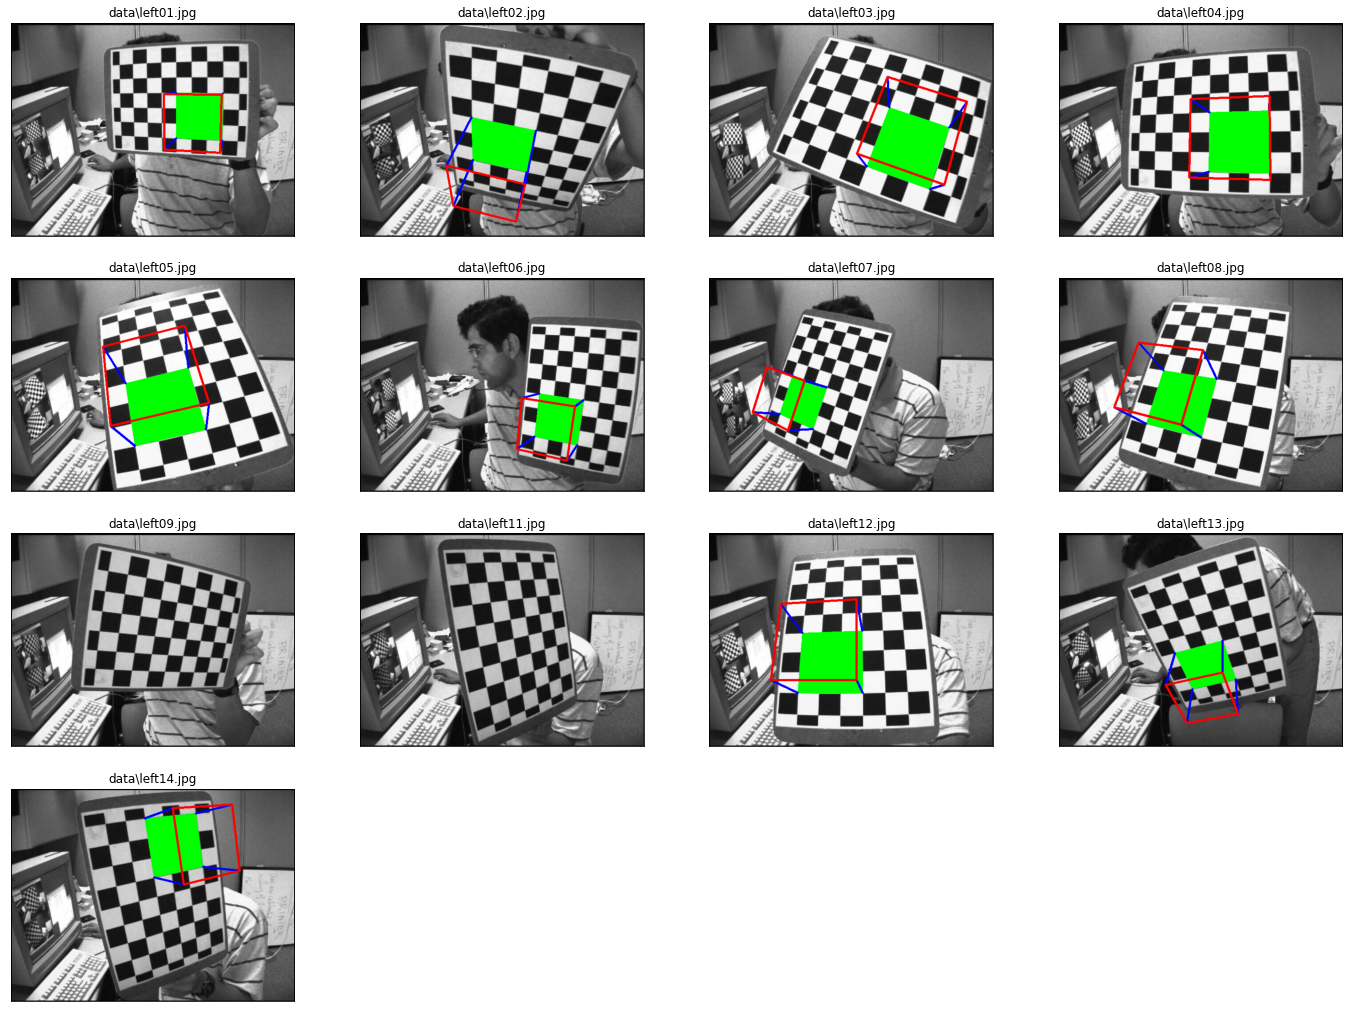

In [7]:
from matplotlib import pyplot as plt

images = glob.glob('data/left*.jpg')

plt.figure(figsize=(24,18))

for i in range(len(images)):
    img = cv.imread(images[i])

    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, (7,6),None)

    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # 找到旋转和平移矢量。
        ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)

        # 将3D点投影到图像平面
        imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)

        img = draw(img,corners2,imgpts)

    plt.subplot(4,4,i+1),plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(images[i])
    plt.xticks([]), plt.yticks([])

plt.show()

如果您对图形，增强现实等感兴趣，则可以使用OpenGL渲染更复杂的图形。
 
### 附加资源
### 练习